In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder

from melusine import load_email_data

# Text input 
df_emails_preprocessed = load_email_data(type="full")
df_emails_preprocessed['clean_text'] = df_emails_preprocessed['clean_header'] + " " + df_emails_preprocessed['clean_body']

In [2]:
# Requirement : have a pretrained Embedding
from melusine.nlp_tools.embedding import Embedding
pretrained_embedding = Embedding(tokens_column="tokens", workers=1, min_count=5)
pretrained_embedding.train(df_emails_preprocessed)

In [3]:
# Metadata input
df_meta = pd.read_csv('/home/jupyter/melusine/melusine/data/metadata.csv', encoding='utf-8', sep=',')

# Dataset
X = pd.concat([df_emails_preprocessed['clean_text'],df_meta],axis=1)
y = df_emails_preprocessed['label']
le = LabelEncoder()
y = le.fit_transform(y)

In [4]:
import ast
import pandas as pd
import numpy as np
df_emails_preprocessed = pd.read_pickle('/home/jupyter/melusine/melusine/data/emails_preprocessed.pkl')

df_emails_preprocessed['clean_header'] = df_emails_preprocessed['clean_header'].astype(str)
df_emails_preprocessed['clean_body'] = df_emails_preprocessed['clean_body'].astype(str)
df_emails_preprocessed['attachment'] = df_emails_preprocessed['attachment'].apply(ast.literal_eval)
df_emails_preprocessed['clean_text'] = df_emails_preprocessed['clean_header'] + " " + df_emails_preprocessed['clean_body']

In [5]:
X = pd.concat([df_emails_preprocessed['clean_text'],df_meta],axis=1)

In [6]:
from sklearn.preprocessing import LabelEncoder
y = df_emails_preprocessed['label']
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
from melusine.models.train import NeuralModel

In [8]:
len(np.unique(y))

11

# Deterministic model

#### The deterministic model is able to give us **point estimation**. 

In [9]:
from melusine.models.neural_architectures import cnn_model
deterministic_nn_model = NeuralModel(architecture_function=cnn_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=['extension','attachment_type', 'dayofweek', 'hour', 'min'],
                       n_epochs=40)

In [10]:
deterministic_nn_model.fit(X,y,tensorboard_log_dir="tutorial/data")
accuracy_deterministic = deterministic_nn_model.score(X, y)

Epoch 1/40
2/2 [==============================] - 2s 223ms/step - loss: 2.3748 - accuracy: 0.1750
Epoch 2/40
2/2 [==============================] - 0s 59ms/step - loss: 2.2858 - accuracy: 0.3000
Epoch 3/40
2/2 [==============================] - 0s 58ms/step - loss: 2.0559 - accuracy: 0.3250
Epoch 4/40
2/2 [==============================] - 0s 57ms/step - loss: 2.0926 - accuracy: 0.3250
Epoch 5/40
2/2 [==============================] - 0s 58ms/step - loss: 1.9305 - accuracy: 0.3750
Epoch 6/40
2/2 [==============================] - 0s 65ms/step - loss: 1.9289 - accuracy: 0.3750
Epoch 7/40
2/2 [==============================] - 0s 58ms/step - loss: 2.0176 - accuracy: 0.2500
Epoch 8/40
2/2 [==============================] - 0s 65ms/step - loss: 1.8580 - accuracy: 0.3500
Epoch 9/40
2/2 [==============================] - 0s 67ms/step - loss: 1.7907 - accuracy: 0.3500
Epoch 10/40
2/2 [==============================] - 0s 46ms/step - loss: 1.8914 - accuracy: 0.3000
Epoch 11/40
2/2 [===========

In [11]:
deterministic_nn_model.predict_proba(X)[:2]

array([[5.6272461e-03, 5.6129405e-03, 3.6340181e-03, 9.4159946e-02,
        7.6462626e-02, 1.5297205e-03, 2.4778416e-02, 3.4313216e-03,
        6.2838518e-03, 4.4276072e-03, 7.7405232e-01],
       [5.4968743e-05, 8.0955775e-05, 3.1114527e-05, 2.1548890e-02,
        1.8399856e-04, 7.6898268e-06, 8.2840741e-04, 5.0160184e-04,
        1.6383738e-04, 9.8461976e-05, 9.7650015e-01]], dtype=float32)

In [12]:
deterministic_nn_model.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     5700        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 200)     120200      embedding[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 200)     0           conv1d[0][0]                     
______________________________________________________________________________________________

#### We can propose a way to have **uncertainty estimation**

# The probabilitic model 
The probabilitic gives us not longer point estimation but distribution on predictions. It allows us to give prediction intervals.

In [13]:
from melusine.models.probabilistic_neural_architectures import probabilistic_cnn_with_meta_model
probabilistic_model = NeuralModel(architecture_function=probabilistic_cnn_with_meta_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=['extension','attachment_type', 'dayofweek', 'hour', 'min'],
                       n_epochs=40)

In [14]:
probabilistic_model.fit(X,y,tensorboard_log_dir="tutorial/data")
accuracy_probabilistic = probabilistic_model.score(X, y)

Epoch 1/40
2/2 [==============================] - 2s 317ms/step - loss: 2.3838 - accuracy: 0.1500
Epoch 2/40
2/2 [==============================] - 0s 53ms/step - loss: 2.2982 - accuracy: 0.3000
Epoch 3/40
2/2 [==============================] - 0s 71ms/step - loss: 2.1774 - accuracy: 0.3000
Epoch 4/40
2/2 [==============================] - 0s 55ms/step - loss: 2.1223 - accuracy: 0.3250
Epoch 5/40
2/2 [==============================] - 0s 54ms/step - loss: 2.1039 - accuracy: 0.3000
Epoch 6/40
2/2 [==============================] - 0s 53ms/step - loss: 1.9891 - accuracy: 0.2750
Epoch 7/40
2/2 [==============================] - 0s 48ms/step - loss: 1.8993 - accuracy: 0.3750
Epoch 8/40
2/2 [==============================] - 0s 57ms/step - loss: 1.9035 - accuracy: 0.3000
Epoch 9/40
2/2 [==============================] - 0s 56ms/step - loss: 1.7836 - accuracy: 0.3750
Epoch 10/40
2/2 [==============================] - 0s 62ms/step - loss: 1.8436 - accuracy: 0.3250
Epoch 11/40
2/2 [===========

### The estimation of the probability is now the mean of the distribution of the prediction

The output of the model is not a **vector** but a **distribution** we can :
- sample
- compute mean
- compute std

In [15]:
X_input = probabilistic_model.prepare_email_to_predict(X)
output = probabilistic_model.model(X_input)
output

<tfp.distributions.OneHotCategorical 'model_1_one_hot_categorical_OneHotCategorical_OneHotCategorical' batch_shape=[40] event_shape=[11] dtype=float32>

#### We can have a **point estimation** using the **mode** or the **mean**

In [16]:
output.mean().numpy().round(1)[:2]

array([[0. , 0. , 0. , 0.1, 0. , 0.1, 0.1, 0. , 0. , 0. , 0.7],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.9]],
      dtype=float32)

In [17]:
output.mode()[:2]

<tf.Tensor: shape=(2, 11), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

#### We can have the **standard deviation** of the distributions

In [18]:
output.stddev().numpy().round(1)[:2]

array([[0.2, 0.1, 0.2, 0.3, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5],
       [0.1, 0.1, 0.1, 0.2, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.3]],
      dtype=float32)

#### We can even **sample** the distributions

In [19]:
output.sample()[:2]

<tf.Tensor: shape=(2, 11), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

#### The mode is used for `predict`

In [20]:
probabilistic_model.predict(X)[:2]

array([10, 10])

#### The mean is used for `predict_proba`

In [21]:
probabilistic_model.predict_proba(X).round(1)[:2]

array([[0. , 0. , 0. , 0.1, 0. , 0.1, 0.1, 0. , 0. , 0. , 0.7],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.9]],
      dtype=float32)

#### And prediction intervals are made by combining **mean** and **std** (gaussian hypothesis)

In [22]:
score, inf, sup = probabilistic_model.predict_proba(X, prediction_interval=0.95)

In [23]:
lower_boundary = (score - inf).round(1)[:2]
lower_boundary

array([[0.4, 0.2, 0.4, 0.5, 0.3, 0.5, 0.4, 0.2, 0.2, 0.3, 0.9],
       [0.3, 0.1, 0.2, 0.4, 0.1, 0.3, 0.3, 0.2, 0.2, 0.2, 0.7]],
      dtype=float32)

In [24]:
upper_boundary = (score + sup).round(1)[:2]
upper_boundary

array([[0.4, 0.3, 0.4, 0.7, 0.4, 0.6, 0.5, 0.2, 0.3, 0.3, 2.2],
       [0.3, 0.1, 0.2, 0.5, 0.1, 0.3, 0.4, 0.2, 0.2, 0.2, 2.4]],
      dtype=float32)

In [25]:
import matplotlib.pyplot as plt
ntargets = 11


def analyse_and_plot_model_predictions(data, true_labels, nn_model, text_num, pi=0.95):
    """
    Make plots of the probabilities that the model estimates for a given text
    """
    true_label = true_labels[text_num]
    true_label_decoded = le.inverse_transform([true_label])[0]
    print('True label: \033[1m \033[92m {} \033[0m'.format(str(true_label_decoded)))
    print('Clean text: ', data.loc[text_num, "clean_text"])
    model_prediction, pct_low, pct_up = nn_model.predict_proba(data.loc[text_num:text_num], prediction_interval=pi)
    model_prediction, pct_low, pct_up = model_prediction[0], pct_low[0], pct_up[0]
    x_pos = np.arange(ntargets)
    bar = plt.bar(x_pos, pct_up, color='red')
    all_categories_decoded = le.inverse_transform(np.arange(ntargets))
    plt.xticks(x_pos, all_categories_decoded, color='black', rotation=45, fontweight='bold', fontsize='10', horizontalalignment='right')
    ax = plt.gca()
    labels = ax.get_xticklabels()
    ticks = ax.get_xticks()
    for label, tick in zip(labels, ticks):
        if tick == true_label:
            label.set_color('green')
    bar[true_label].set_color('green')
    plt.bar(np.arange(ntargets), pct_low-0.02, color='white', linewidth=1, edgecolor='white')
    plt.ylim([0, 1])
    plt.ylabel('Probability')
    plt.title('Model estimated probabilities') 
    plt.show()

True label:   vehicule 
Clean text:  assurance vehicules je me permets de venir vers vous car depuis le debut de lannee, nous avons des difficultes pour assurer nos vehicules. ces derniers jours, vous nous avez fait parvenir le detail des denominations et des niveau dassurance de chaque vehicule. merci deffectuer ces changements dans lattente de votre retour


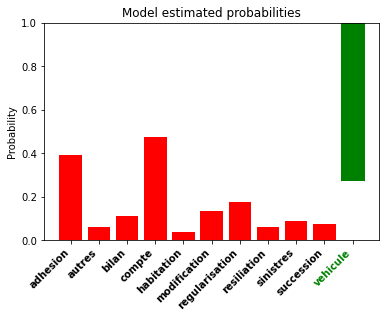

In [26]:
i = 7
analyse_and_plot_model_predictions(X, y, probabilistic_model, text_num=i, pi=0.95)

### Disclaimer
The dataset of this melusine tutorial is so small (40 emails) the model is always drawing large intervals. On the previous example the prediction interval may be [0;1] (thank you captain obvious). We would rather consider small (more informative) intervals.


But if we apply this method on a large public datasets (like the movies dataset : 100 000 movies plots) we can see predictions with less uncertainty as on the following image. With disjointed intervals.

<img src="images/uncertainty-on-movies-dataset.png" width=400 height=400 />

To let us see small interval (as a sanity check) we also can choose a very small prediction interval (0.2 instead of 0.95, but obviously 0.2 is not a serious value for prediction intervals) as on the following.

True label:   vehicule 
Clean text:  assurance vehicules je me permets de venir vers vous car depuis le debut de lannee, nous avons des difficultes pour assurer nos vehicules. ces derniers jours, vous nous avez fait parvenir le detail des denominations et des niveau dassurance de chaque vehicule. merci deffectuer ces changements dans lattente de votre retour


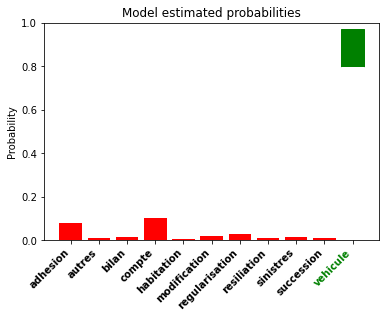

In [27]:
i = 7
analyse_and_plot_model_predictions(X, y, probabilistic_model, text_num=i, pi=0.2)

So instead of just having a point estimation score of being a `vehicle` verbatim (score=0.2) we can have uncertainty estimation around a point estimation (the score of being `vehicle` verbatim is in the interval [0.1 ; 0.3] with a 95% prediction interval).

# To go further : variational neural networks
We can try a variational neural networks : [`Flipout`](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/conv_variational)

In [28]:
from melusine.models.probabilistic_neural_architectures import flipout_cnn_model
flipout_nn_model = NeuralModel(architecture_function=flipout_cnn_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=['extension','attachment_type', 'dayofweek', 'hour', 'min'],
                       n_epochs=40)

In [29]:
flipout_nn_model.fit(X,y,tensorboard_log_dir="tutorial/data")
accuracy_flipout= flipout_nn_model.score(X, y)

Epoch 1/40
2/2 [==============================] - 3s 427ms/step - loss: 18802.0840 - accuracy: 0.2000
Epoch 2/40
2/2 [==============================] - 0s 31ms/step - loss: 18786.4531 - accuracy: 0.2000
Epoch 3/40
2/2 [==============================] - 0s 31ms/step - loss: 18770.8516 - accuracy: 0.2000
Epoch 4/40
2/2 [==============================] - 0s 31ms/step - loss: 18755.2812 - accuracy: 0.2000
Epoch 5/40
2/2 [==============================] - 0s 32ms/step - loss: 18739.7441 - accuracy: 0.2000
Epoch 6/40
2/2 [==============================] - 0s 33ms/step - loss: 18724.2383 - accuracy: 0.2000
Epoch 7/40
2/2 [==============================] - 0s 45ms/step - loss: 18708.7656 - accuracy: 0.2000
Epoch 8/40
2/2 [==============================] - 0s 44ms/step - loss: 18693.3223 - accuracy: 0.2000
Epoch 9/40
2/2 [==============================] - 0s 63ms/step - loss: 18677.9102 - accuracy: 0.2000
Epoch 10/40
2/2 [==============================] - 0s 64ms/step - loss: 18662.5273 - accur

In [30]:
flipout_nn_model.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     6900        input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_flipout (Conv1DFlipout)  (None, 100, 128)     230528      embedding_2[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 66)]         0                                            
____________________________________________________________________________________________

### Another disclaimer
The tutorial dataset is too small for our flipout model.

True label:   vehicule 
Clean text:  pret vehicule ci-joint pret vehicule


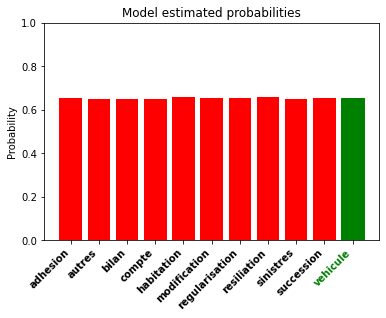

In [31]:
i = 9
analyse_and_plot_model_predictions(X, y, flipout_nn_model, i)

### Quick summary
We show 2 probabilistic models :
- **basic probabilistic** model with just a [OneHotCategorical](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/OneHotCategorical) as last (prediction) layer

- **flipout** model with [Convolution1DFlipout](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/Convolution1DFlipout) layers

We made simulations on a larger dataset (the movies plots dataset) to see if the probabilistic models had a good enough performance.

The basic probabilistic model is an effective lowcost solution to have uncertainty estimation of the prediction without any performance loss.

On our case, we did not manage to design a variational (flipout) neural architecture to get this level of performance.